# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.12.1+cu113
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

MessageError: ignored

# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [2]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2022-11-29 23:18:33--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  1.87MB/s    in 1.2s    

2022-11-29 23:18:35 (1.87 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [3]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [18]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()

    # TODO Add more preprocessing
    data = re.sub(r'[\r\n\t\s]+',' ', data)
    
    voc2ind = {}
    i = 0

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = i
            i += 1

    train_size = int(len(data) * 0.8)

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:train_size]
    test_text = data[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [19]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = dataset['tokens']
        voc2ind = dataset['voc2ind']

        n = len(tokens) - (len(tokens) % batch_size)
        self.data = torch.LongTensor([voc2ind[tokens[i]] for i in range(n)]).view(batch_size, -1)
        self.len = self.data.shape[0] * int(np.ceil((self.data.shape[1] - 1) / self.sequence_length))


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.len
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size
        seq_idx = idx // self.batch_size

        seq_start_idx = seq_idx * self.sequence_length
        seq_end_idx = min(seq_start_idx + self.sequence_length + 1, self.data.shape[1])

        data = self.data[batch_idx][seq_start_idx:seq_end_idx]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [6]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [7]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = output[0].argmax().long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = torch.multinomial(output[0], 1)[0].long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    # TODO
    for ii in range(sequence_length):
        new_beams = []
        for curr_beam in beam:
            for sample in torch.multinomial(curr_beam[1][0], beam_width, replacement=True):
                sample = sample.long()
                score = curr_beam[3] + torch.log(curr_beam[1][0][sample])
                output, hidden = model.inference(sample, curr_beam[2], TEMPERATURE)
                new_beams.append((curr_beam[0] + [sample], output, hidden, score))
        new_beams.sort(key = lambda b: b[3], reverse=True)
        beam = new_beams[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [8]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/logs/0.1/015.pt
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet sulntand soavid atainst the care  oaasl  "I wm serri".  "e said  "Wun't larry  tor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the ctt r ahre  a

  1%|          | 1/195 [00:00<00:27,  7.10it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.340763


  7%|▋         | 13/195 [00:01<00:15, 11.96it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.370222


 12%|█▏        | 23/195 [00:01<00:14, 12.16it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.334352


 17%|█▋        | 33/195 [00:02<00:13, 12.29it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.330112


 22%|██▏       | 43/195 [00:03<00:12, 12.15it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.311557


 27%|██▋       | 53/195 [00:04<00:11, 12.15it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.301026


 32%|███▏      | 63/195 [00:05<00:10, 12.34it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.315676


 37%|███▋      | 73/195 [00:06<00:10, 12.08it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.310548


 43%|████▎     | 83/195 [00:06<00:09, 12.03it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.301338


 48%|████▊     | 93/195 [00:07<00:08, 12.17it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.306890


 53%|█████▎    | 103/195 [00:08<00:07, 12.33it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.310775


 58%|█████▊    | 113/195 [00:09<00:06, 12.04it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.298970


 63%|██████▎   | 123/195 [00:10<00:06, 11.98it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.311409


 68%|██████▊   | 133/195 [00:10<00:05, 12.03it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.323468


 73%|███████▎  | 143/195 [00:11<00:04, 11.92it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.324275


 78%|███████▊  | 153/195 [00:12<00:03, 11.80it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.315289


 84%|████████▎ | 163/195 [00:13<00:02, 11.92it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.297393


 89%|████████▊ | 173/195 [00:14<00:01, 11.87it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.293937


 94%|█████████▍| 183/195 [00:15<00:01, 11.76it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.293340


 99%|█████████▉| 193/195 [00:16<00:00, 11.79it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.316613


100%|██████████| 195/195 [00:16<00:00, 12.01it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet stlntand soavid atainst the sore aatisl  "I dm serri".  "e said  "Iun't yarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the ctt r ahre  and tarry saaded humbledore aeck tnto the cne otatsrer ahet horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd sienpeng hn the caddle of the cork aashtanuaet on tagwmeade  "ir ane oewrible aorent tarry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:29,  6.50it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.323457


  6%|▌         | 12/195 [00:01<00:15, 11.81it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.319663


 11%|█▏        | 22/195 [00:01<00:14, 12.04it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.316912


 16%|█▋        | 32/195 [00:02<00:13, 11.84it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.325581


 22%|██▏       | 42/195 [00:03<00:12, 11.79it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.309779


 27%|██▋       | 52/195 [00:04<00:12, 11.65it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.302127


 32%|███▏      | 62/195 [00:05<00:11, 11.75it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.315966


 37%|███▋      | 72/195 [00:06<00:10, 11.98it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.311157


 42%|████▏     | 82/195 [00:07<00:09, 11.77it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.302012


 47%|████▋     | 92/195 [00:07<00:08, 11.79it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.310007


 52%|█████▏    | 102/195 [00:08<00:07, 11.87it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.311870


 57%|█████▋    | 112/195 [00:09<00:07, 11.82it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.299440


 63%|██████▎   | 122/195 [00:10<00:06, 11.86it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.312691


 68%|██████▊   | 132/195 [00:11<00:05, 11.85it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.323412


 73%|███████▎  | 142/195 [00:12<00:04, 11.69it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.323776


 78%|███████▊  | 152/195 [00:12<00:03, 11.81it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.315947


 83%|████████▎ | 162/195 [00:13<00:02, 11.81it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.296160


 88%|████████▊ | 172/195 [00:14<00:01, 11.74it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.293898


 93%|█████████▎| 182/195 [00:15<00:01, 11.90it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.293279


 98%|█████████▊| 192/195 [00:16<00:00, 11.70it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.313210


100%|██████████| 195/195 [00:16<00:00, 11.72it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet sulntand soavid atainst the sare aatisl  "I dm aerri".  "e said  "Iun't tarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the ctt r ahre  and tarry saaded humbledore aeck tnto the cnk otatsrer ahet horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd saenpeng tn the caddle of the cork aashtanuaet on tagwmeade  "ir ane oawrible aorent tarry


Input	help, but there was nobody to be seen

  1%|          | 1/195 [00:00<00:37,  5.16it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.323019


  7%|▋         | 13/195 [00:01<00:15, 11.74it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.319350


 12%|█▏        | 23/195 [00:02<00:14, 12.13it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.316340


 17%|█▋        | 33/195 [00:02<00:13, 12.03it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.324772


 22%|██▏       | 43/195 [00:03<00:12, 12.18it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.308697


 27%|██▋       | 53/195 [00:04<00:11, 11.95it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.300467


 32%|███▏      | 63/195 [00:05<00:10, 12.16it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.314585


 37%|███▋      | 73/195 [00:06<00:09, 12.31it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.309700


 43%|████▎     | 83/195 [00:06<00:09, 12.07it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.301330


 48%|████▊     | 93/195 [00:07<00:08, 12.01it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.309031


 53%|█████▎    | 103/195 [00:08<00:07, 12.10it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.309969


 58%|█████▊    | 113/195 [00:09<00:06, 12.07it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.297710


 63%|██████▎   | 123/195 [00:10<00:05, 12.19it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.310862


 68%|██████▊   | 133/195 [00:11<00:05, 12.26it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.322021


 73%|███████▎  | 143/195 [00:11<00:04, 12.21it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.322890


 78%|███████▊  | 153/195 [00:12<00:03, 12.05it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.314291


 84%|████████▎ | 163/195 [00:13<00:02, 12.27it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.295292


 89%|████████▊ | 173/195 [00:14<00:01, 12.22it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.292775


 94%|█████████▍| 183/195 [00:15<00:00, 12.18it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.291898


 99%|█████████▉| 193/195 [00:16<00:00, 12.05it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.310938


100%|██████████| 195/195 [00:16<00:00, 12.01it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet sulntand soavid anainst the sare aatisl  "I dm aerri".  "e said  "Iun't tarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the ctt r ahre  and tarry saaded humbledore aeck tnto the cnk otatsrir ahet horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd saanpeng hn the caddle of the cork aashtanuaet on tagwmeade  "ir ane oawrible aorent tarry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:29,  6.61it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.321782


  6%|▌         | 12/195 [00:01<00:15, 11.73it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.317997


 11%|█▏        | 22/195 [00:01<00:14, 12.19it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.314333


 16%|█▋        | 32/195 [00:02<00:13, 12.32it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.323327


 22%|██▏       | 42/195 [00:03<00:12, 12.28it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.307065


 27%|██▋       | 52/195 [00:04<00:11, 12.29it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.298455


 32%|███▏      | 62/195 [00:05<00:10, 12.25it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.312979


 37%|███▋      | 72/195 [00:06<00:10, 12.12it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.307781


 42%|████▏     | 82/195 [00:06<00:09, 12.18it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.299417


 47%|████▋     | 92/195 [00:07<00:08, 12.29it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.307394


 52%|█████▏    | 102/195 [00:08<00:07, 12.13it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.308381


 57%|█████▋    | 112/195 [00:09<00:06, 12.08it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.296065


 63%|██████▎   | 122/195 [00:10<00:05, 12.31it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.309070


 68%|██████▊   | 132/195 [00:10<00:05, 12.20it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.320658


 73%|███████▎  | 142/195 [00:11<00:04, 11.86it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.321706


 78%|███████▊  | 152/195 [00:12<00:03, 12.02it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.312715


 83%|████████▎ | 162/195 [00:13<00:02, 12.05it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.293983


 88%|████████▊ | 172/195 [00:14<00:01, 12.12it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.291267


 93%|█████████▎| 182/195 [00:15<00:01, 11.98it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.290087


 98%|█████████▊| 192/195 [00:15<00:00, 12.02it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.309123


100%|██████████| 195/195 [00:16<00:00, 12.03it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet sulntand soavid atainst the sore aatisl  "I wm aerri".  "e said  "Iun't tarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the ctt r aore  and tarry saaded humbledore aeck tnto the cnk otatsrir ahet horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd saanpeng hn the caddle of the cork aashtanuaet an tagwmeade  "ir ane oawrible aorent tarry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:29,  6.53it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.320346


  6%|▌         | 12/195 [00:01<00:16, 11.28it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.316447


 11%|█▏        | 22/195 [00:01<00:14, 12.05it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.312304


 16%|█▋        | 32/195 [00:02<00:13, 12.09it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.321805


 22%|██▏       | 42/195 [00:03<00:12, 12.16it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.305507


 27%|██▋       | 52/195 [00:04<00:11, 12.15it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.296480


 32%|███▏      | 62/195 [00:05<00:10, 12.19it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.311189


 37%|███▋      | 72/195 [00:06<00:10, 12.17it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.305843


 42%|████▏     | 82/195 [00:06<00:09, 12.28it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.297462


 47%|████▋     | 92/195 [00:07<00:08, 12.11it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.305618


 52%|█████▏    | 102/195 [00:08<00:07, 12.07it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.306804


 57%|█████▋    | 112/195 [00:09<00:06, 12.18it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.294441


 63%|██████▎   | 122/195 [00:10<00:05, 12.33it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.307321


 68%|██████▊   | 132/195 [00:11<00:05, 11.96it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.319280


 73%|███████▎  | 142/195 [00:11<00:04, 11.89it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.320450


 78%|███████▊  | 152/195 [00:12<00:03, 12.04it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.311326


 83%|████████▎ | 162/195 [00:13<00:02, 12.06it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.292522


 88%|████████▊ | 172/195 [00:14<00:01, 12.03it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.289705


 93%|█████████▎| 182/195 [00:15<00:01, 11.81it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.288236


 98%|█████████▊| 192/195 [00:16<00:00, 11.75it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.307505


100%|██████████| 195/195 [00:16<00:00, 11.93it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet sulntand soavid atainst the sore aatisl  "I wm aerri".  "e said  "Ion't tarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the ctt r aore  and tarry saaded humbledore aeck tnto the cnk otatsrir ahat horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd saanpeng hn the caddle of the cork aashtanuaet an tagwmeade  "ir ane oawrible aorent tarry


Input	help, but there was nobody to be seen

  1%|          | 1/195 [00:00<00:37,  5.23it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.318868


  6%|▌         | 12/195 [00:01<00:15, 11.67it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.314958


 11%|█▏        | 22/195 [00:01<00:14, 12.20it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.310369


 16%|█▋        | 32/195 [00:02<00:13, 12.28it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.320351


 22%|██▏       | 42/195 [00:03<00:12, 12.02it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.304027


 27%|██▋       | 52/195 [00:04<00:11, 12.23it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.294653


 32%|███▏      | 62/195 [00:05<00:10, 12.10it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.309439


 37%|███▋      | 72/195 [00:06<00:10, 12.01it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.303983


 42%|████▏     | 82/195 [00:06<00:09, 12.19it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.295575


 47%|████▋     | 92/195 [00:07<00:08, 12.21it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.303869


 52%|█████▏    | 102/195 [00:08<00:07, 12.22it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.305261


 57%|█████▋    | 112/195 [00:09<00:06, 12.00it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.292846


 63%|██████▎   | 122/195 [00:10<00:06, 12.11it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.305639


 68%|██████▊   | 132/195 [00:11<00:05, 11.98it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.317957


 73%|███████▎  | 142/195 [00:11<00:04, 11.86it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.319176


 78%|███████▊  | 152/195 [00:12<00:03, 12.17it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.310088


 83%|████████▎ | 162/195 [00:13<00:02, 12.19it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.291049


 88%|████████▊ | 172/195 [00:14<00:01, 11.90it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.288261


 93%|█████████▎| 182/195 [00:15<00:01, 11.87it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.286484


 98%|█████████▊| 192/195 [00:16<00:00, 11.99it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.306036


100%|██████████| 195/195 [00:16<00:00, 11.96it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet sulntand soavid atainst the sore aatisl  "I wm serri".  "e said  "Ion't tarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the ctt r aore  and tarry saaded humbledore aeck tnto the cnk otatsrir ahat horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd saanpeng tn the caddle of the cork aashtanuaet an tagwmeade  "ir ane oaurible aorent tarry


Input	help, but there was nobody to be seen

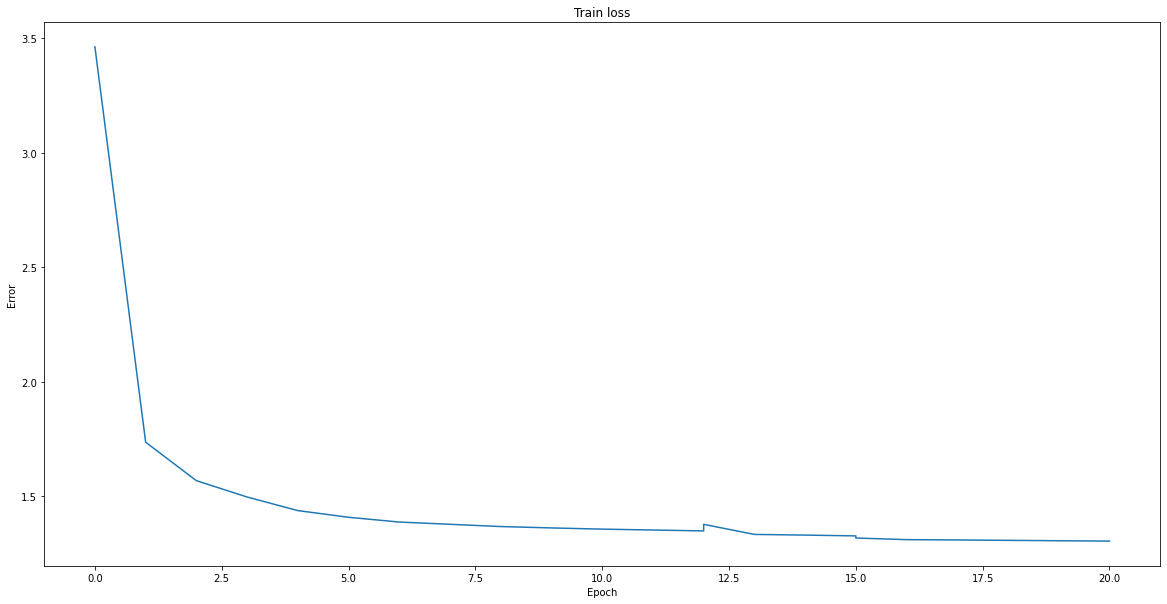

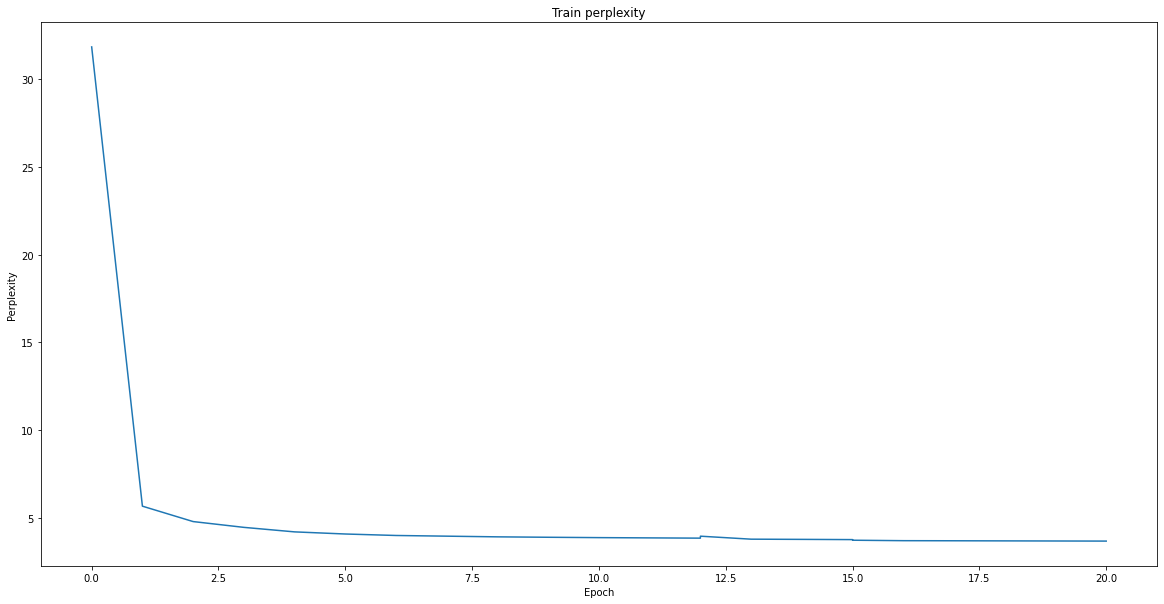

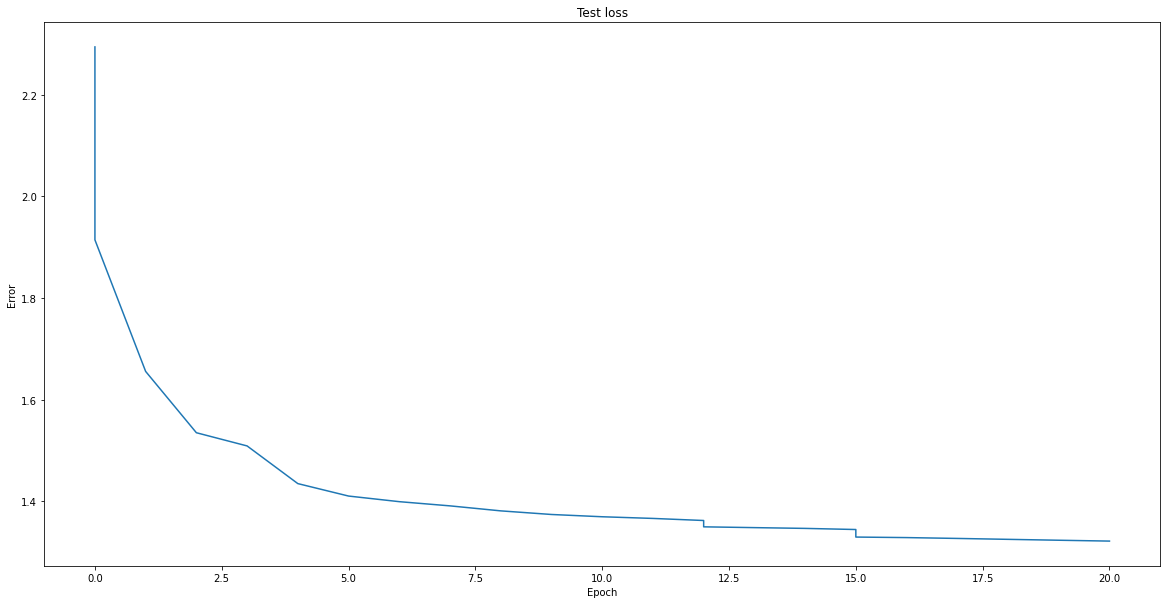

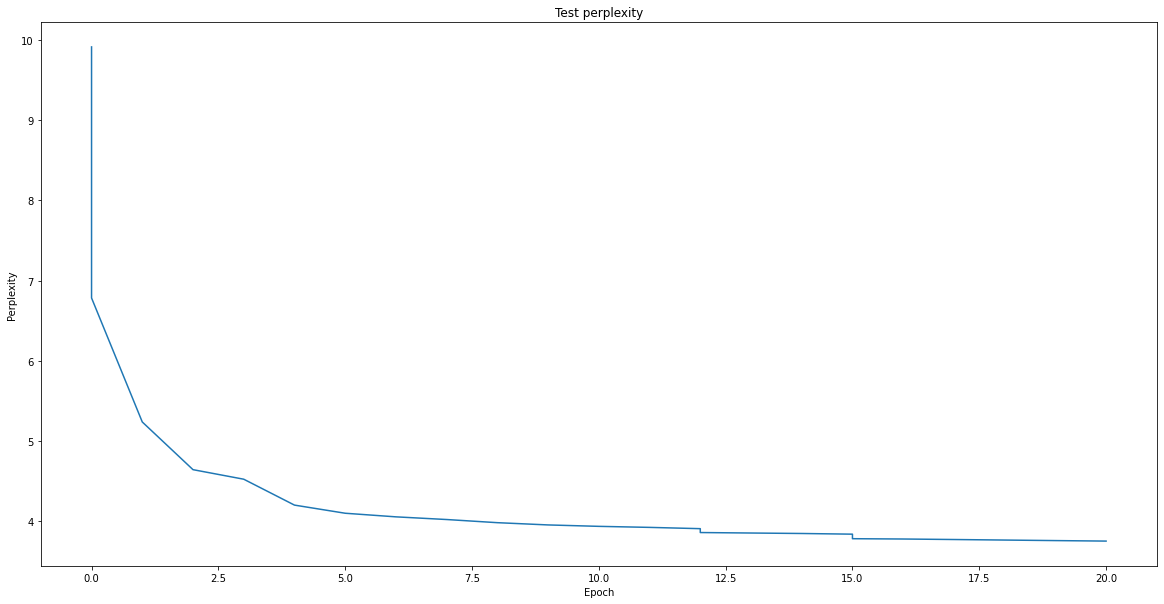

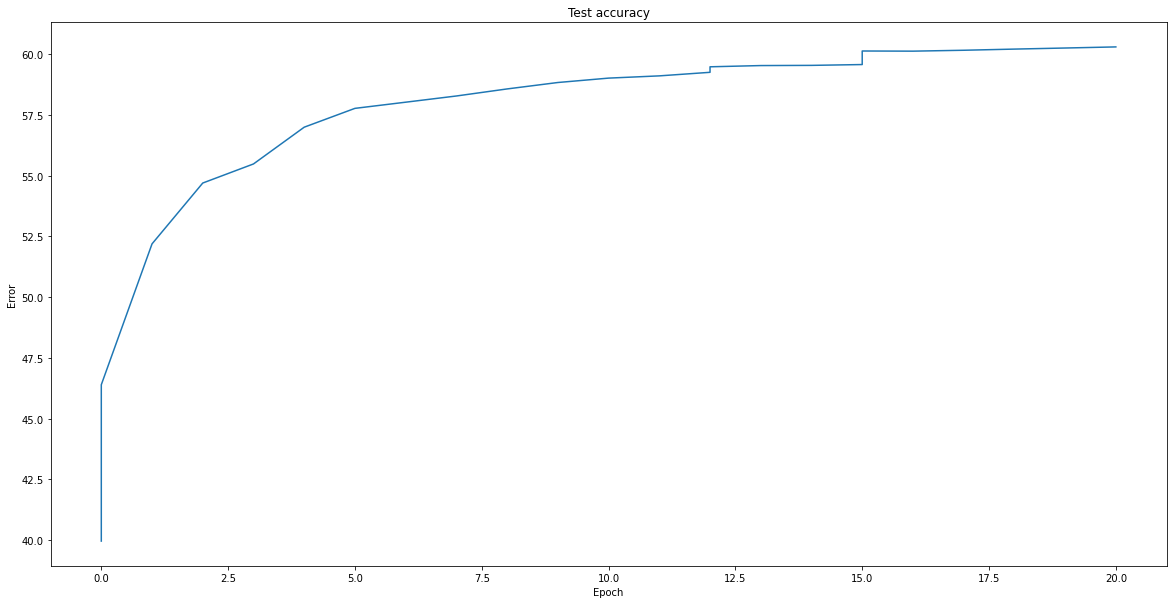

Final test accuracy: 60.3093112244898
Final test perplexity: 3.749268101584715


In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '0.1'
    LOG_PATH = DATA_PATH + 'logs/' + VERSION + '/'

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        train_perplexity = np.exp(val)
        pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        test_perplexity = np.exp(val)
        pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
        print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
        print('Final test perplexity: {}'.format(test_perplexity[-1]))
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry laughed'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry laughed and started to the stairs and said, "I think you want to be a lot of the catch of the castle and the start of the car of the castle and the start of the card of the castle and the start of the card a
generated with sample	 Harry laughed and started to the stairs and said, "I think you want to be a lot of the catch of the castle and the start of the car of the castle and the start of the card of the castle and the start of the card a
generated with sample	 Harry laughed, and the start of the car to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corrid
generated with sample	 Harry laughed, and the start of the car to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corrid
generated with sample	 Harry laughed and started to the

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



## Part 8.1 Train on different corpus: Lord of the Ring

In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'lotr.txt')):
    os.chdir(BASE_PATH)
    !cp lotr.txt /content
os.chdir('/content')

In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()

    # TODO Add more preprocessing
    data = re.sub(r'[\r\n\t\s]+',' ', data)
    print(len(data))
    
    voc2ind = {}
    i = 0

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = i
            i += 1

    train_size = int(len(data) * 0.8)

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:train_size]
    test_text = data[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'lotr_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'lotr_chars_test.pkl', 'wb'))

prepare_data(DATA_PATH + 'lotr.txt')

2523660


Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([94, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([94, 512]) = 0MB
decoder.bias -> 	torch.Size([94]) = 0MB

Restored all variables
No new variables
Restored /content/logs/lotr/0.1/020.pt
Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said that te was aoing   se sadhed. aand tot te ts teed.  'Io,  said Gippin. aaot tot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tieth treat sorss

  1%|▏         | 1/79 [00:00<00:11,  6.91it/s]

Train Epoch: 20 [0/20224 (0%)]	Loss: 1.355943


 16%|█▋        | 13/79 [00:01<00:05, 11.80it/s]

Train Epoch: 20 [2560/20224 (13%)]	Loss: 1.520788


 29%|██▉       | 23/79 [00:01<00:04, 12.09it/s]

Train Epoch: 20 [5120/20224 (25%)]	Loss: 1.394716


 42%|████▏     | 33/79 [00:02<00:03, 11.99it/s]

Train Epoch: 20 [7680/20224 (38%)]	Loss: 1.370783


 54%|█████▍    | 43/79 [00:03<00:02, 12.33it/s]

Train Epoch: 20 [10240/20224 (51%)]	Loss: 1.314355


 67%|██████▋   | 53/79 [00:04<00:02, 12.35it/s]

Train Epoch: 20 [12800/20224 (63%)]	Loss: 1.320281


 80%|███████▉  | 63/79 [00:05<00:01, 12.17it/s]

Train Epoch: 20 [15360/20224 (76%)]	Loss: 1.332876


 92%|█████████▏| 73/79 [00:06<00:00, 12.21it/s]

Train Epoch: 20 [17920/20224 (89%)]	Loss: 1.352298


100%|██████████| 79/79 [00:06<00:00, 11.98it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid thet te was aoing   se saghed. aand to  ae ws teed.  'Io,  said Gippin. 'aot tot  Ind tver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	theth treyt srrs toifded tp tefween the walls  Tot tt weemed ttoonge y atnent  Towaotse of teorl  of



Test set: Average loss: 1.3639, Accuracy: 299544/512000 (59%)

Saved /content/logs/lotr/0.1/020.pt

generated max		 Legolas, Gandalf, and Frodo walk into a bar. But the way of the world was still and strong and the wind of the wind and the wind was still and strong the wind of the wind and the road the walls of the stone stone and stone and stone and stone an

  4%|▍         | 3/79 [00:00<00:08,  8.74it/s]

Train Epoch: 21 [0/20224 (0%)]	Loss: 1.326896


 16%|█▋        | 13/79 [00:01<00:05, 11.75it/s]

Train Epoch: 21 [2560/20224 (13%)]	Loss: 1.321776


 29%|██▉       | 23/79 [00:02<00:04, 12.08it/s]

Train Epoch: 21 [5120/20224 (25%)]	Loss: 1.327033


 42%|████▏     | 33/79 [00:02<00:03, 11.90it/s]

Train Epoch: 21 [7680/20224 (38%)]	Loss: 1.350798


 54%|█████▍    | 43/79 [00:03<00:03, 11.87it/s]

Train Epoch: 21 [10240/20224 (51%)]	Loss: 1.309496


 67%|██████▋   | 53/79 [00:04<00:02, 11.86it/s]

Train Epoch: 21 [12800/20224 (63%)]	Loss: 1.320759


 80%|███████▉  | 63/79 [00:05<00:01, 11.81it/s]

Train Epoch: 21 [15360/20224 (76%)]	Loss: 1.336677


 92%|█████████▏| 73/79 [00:06<00:00, 11.92it/s]

Train Epoch: 21 [17920/20224 (89%)]	Loss: 1.355363


100%|██████████| 79/79 [00:06<00:00, 11.68it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid thet te was aoing   se saghed. aand to  ae ws aeed.  'Io,  said Gippin. 'aow tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech treyt sorss ooaded tp tefween the wall   Tot tt weemed ttiange y atnentl Towaowse of woorle of



Test set: Average loss: 1.3642, Accuracy: 299401/512000 (58%)

generated max		 Legolas, Gandalf, and Frodo walk into a bar. But the way of the world and the way of the world and the walls of the world and the walls of the world and stone and stone and stone and stone and stone and stone and stone and stone and stone and st
generated sample	 Legolas, Gandalf, 

  3%|▎         | 2/79 [00:00<00:11,  6.46it/s]

Train Epoch: 22 [0/20224 (0%)]	Loss: 1.330760


 15%|█▌        | 12/79 [00:01<00:05, 11.54it/s]

Train Epoch: 22 [2560/20224 (13%)]	Loss: 1.324082


 28%|██▊       | 22/79 [00:02<00:04, 11.81it/s]

Train Epoch: 22 [5120/20224 (25%)]	Loss: 1.327864


 41%|████      | 32/79 [00:02<00:03, 11.76it/s]

Train Epoch: 22 [7680/20224 (38%)]	Loss: 1.350492


 53%|█████▎    | 42/79 [00:03<00:03, 11.82it/s]

Train Epoch: 22 [10240/20224 (51%)]	Loss: 1.309089


 66%|██████▌   | 52/79 [00:04<00:02, 11.76it/s]

Train Epoch: 22 [12800/20224 (63%)]	Loss: 1.320345


 78%|███████▊  | 62/79 [00:05<00:01, 11.73it/s]

Train Epoch: 22 [15360/20224 (76%)]	Loss: 1.337523


 91%|█████████ | 72/79 [00:06<00:00, 11.75it/s]

Train Epoch: 22 [17920/20224 (89%)]	Loss: 1.353280


100%|██████████| 79/79 [00:06<00:00, 11.45it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid that te was aoing   se saghed. aand to  ae ws aead   'Io,  said Gippin. 'aor tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech taeat sorss oiaded ap aefween the wall   Tot tt weemed ttiange y atnent  Towaotse of woorl  of



Test set: Average loss: 1.3646, Accuracy: 299128/512000 (58%)

generated max		 Legolas, Gandalf, and Frodo walk into a bar. But the way of the world and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and s
generated sample	 Legolas, Gandalf, 

  3%|▎         | 2/79 [00:00<00:11,  6.61it/s]

Train Epoch: 23 [0/20224 (0%)]	Loss: 1.332498


 15%|█▌        | 12/79 [00:01<00:05, 11.31it/s]

Train Epoch: 23 [2560/20224 (13%)]	Loss: 1.321849


 28%|██▊       | 22/79 [00:02<00:04, 11.50it/s]

Train Epoch: 23 [5120/20224 (25%)]	Loss: 1.328828


 41%|████      | 32/79 [00:02<00:04, 11.74it/s]

Train Epoch: 23 [7680/20224 (38%)]	Loss: 1.348178


 53%|█████▎    | 42/79 [00:03<00:03, 11.71it/s]

Train Epoch: 23 [10240/20224 (51%)]	Loss: 1.307678


 66%|██████▌   | 52/79 [00:04<00:02, 11.57it/s]

Train Epoch: 23 [12800/20224 (63%)]	Loss: 1.319947


 78%|███████▊  | 62/79 [00:05<00:01, 11.61it/s]

Train Epoch: 23 [15360/20224 (76%)]	Loss: 1.337451


 91%|█████████ | 72/79 [00:06<00:00, 11.64it/s]

Train Epoch: 23 [17920/20224 (89%)]	Loss: 1.351675


100%|██████████| 79/79 [00:06<00:00, 11.35it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid thet te was aoing   se saghed. aand to  ae ws aead   'Io,  said Gippin. 'aor tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech taeat sorss oiaded ip aefween the sall   Tot tt weemed tliange y atnent  Towaotse of soarl  of



Test set: Average loss: 1.3628, Accuracy: 299253/512000 (58%)

generated max		 Legolas, Gandalf, and Frodo walk into a bar. But the stone was a strange that we can to the stone of the walls of the stones of the world and stone and stone and stone and stone and stone and stone and stone and stone and stone and stone and sto
generated sample	 Legolas, Gandalf, 

  3%|▎         | 2/79 [00:00<00:12,  6.40it/s]

Train Epoch: 24 [0/20224 (0%)]	Loss: 1.330696


 15%|█▌        | 12/79 [00:01<00:05, 11.24it/s]

Train Epoch: 24 [2560/20224 (13%)]	Loss: 1.320508


 28%|██▊       | 22/79 [00:02<00:04, 11.58it/s]

Train Epoch: 24 [5120/20224 (25%)]	Loss: 1.327733


 41%|████      | 32/79 [00:02<00:04, 11.44it/s]

Train Epoch: 24 [7680/20224 (38%)]	Loss: 1.346959


 53%|█████▎    | 42/79 [00:03<00:03, 11.49it/s]

Train Epoch: 24 [10240/20224 (51%)]	Loss: 1.306151


 66%|██████▌   | 52/79 [00:04<00:02, 11.43it/s]

Train Epoch: 24 [12800/20224 (63%)]	Loss: 1.319044


 78%|███████▊  | 62/79 [00:05<00:01, 11.29it/s]

Train Epoch: 24 [15360/20224 (76%)]	Loss: 1.335136


 91%|█████████ | 72/79 [00:06<00:00, 11.11it/s]

Train Epoch: 24 [17920/20224 (89%)]	Loss: 1.348567


100%|██████████| 79/79 [00:07<00:00, 11.13it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid thet te was aoing   se saghed. aand to  ae ws aeadl  'Io,  said Gippin. 'aot tot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech taeat sorss oiaded ip aefween the sall   Tot tt weemed tliange y atnent  Towaotse of soorl  of



Test set: Average loss: 1.3613, Accuracy: 299403/512000 (58%)

generated max		 Legolas, Gandalf, and Frodo walk into a bar. But the stones of the wall of the stones of the walls of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the
generated sample	 Legolas, Gandalf, 

  4%|▍         | 3/79 [00:00<00:09,  8.27it/s]

Train Epoch: 25 [0/20224 (0%)]	Loss: 1.328833


 16%|█▋        | 13/79 [00:01<00:05, 11.19it/s]

Train Epoch: 25 [2560/20224 (13%)]	Loss: 1.319431


 29%|██▉       | 23/79 [00:02<00:04, 11.42it/s]

Train Epoch: 25 [5120/20224 (25%)]	Loss: 1.325513


 42%|████▏     | 33/79 [00:03<00:04, 11.42it/s]

Train Epoch: 25 [7680/20224 (38%)]	Loss: 1.345747


 54%|█████▍    | 43/79 [00:03<00:03, 11.42it/s]

Train Epoch: 25 [10240/20224 (51%)]	Loss: 1.303797


 67%|██████▋   | 53/79 [00:04<00:02, 11.17it/s]

Train Epoch: 25 [12800/20224 (63%)]	Loss: 1.317114


 80%|███████▉  | 63/79 [00:05<00:01, 11.34it/s]

Train Epoch: 25 [15360/20224 (76%)]	Loss: 1.332378


 92%|█████████▏| 73/79 [00:06<00:00, 11.25it/s]

Train Epoch: 25 [17920/20224 (89%)]	Loss: 1.345606


100%|██████████| 79/79 [00:07<00:00, 11.12it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid thet te was aoing   se saghed. aand to  ae ws aeadl  'Io,  said Gippin. 'aot tot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech taeat sorss oiaded ip aefween the sall   Tot tt weemed tliange y atnent  Towaotse of soorl  af



Test set: Average loss: 1.3594, Accuracy: 299655/512000 (59%)

Saved /content/logs/lotr/0.1/025.pt

generated max		 Legolas, Gandalf, and Frodo walk into a bar. But the stones of the wall of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the stones of the stones of th

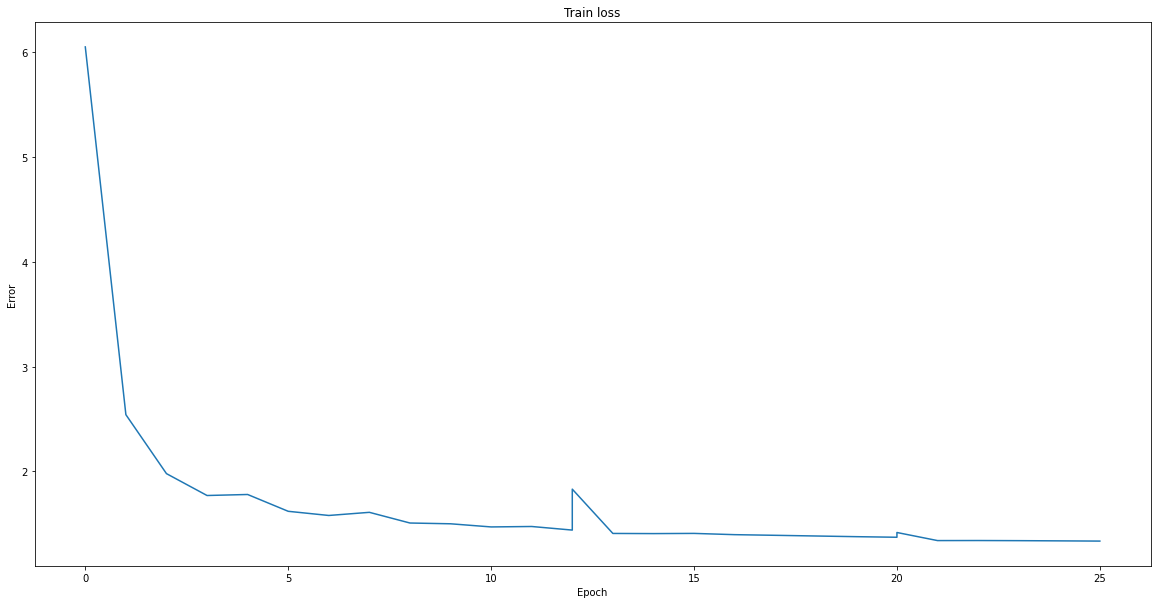

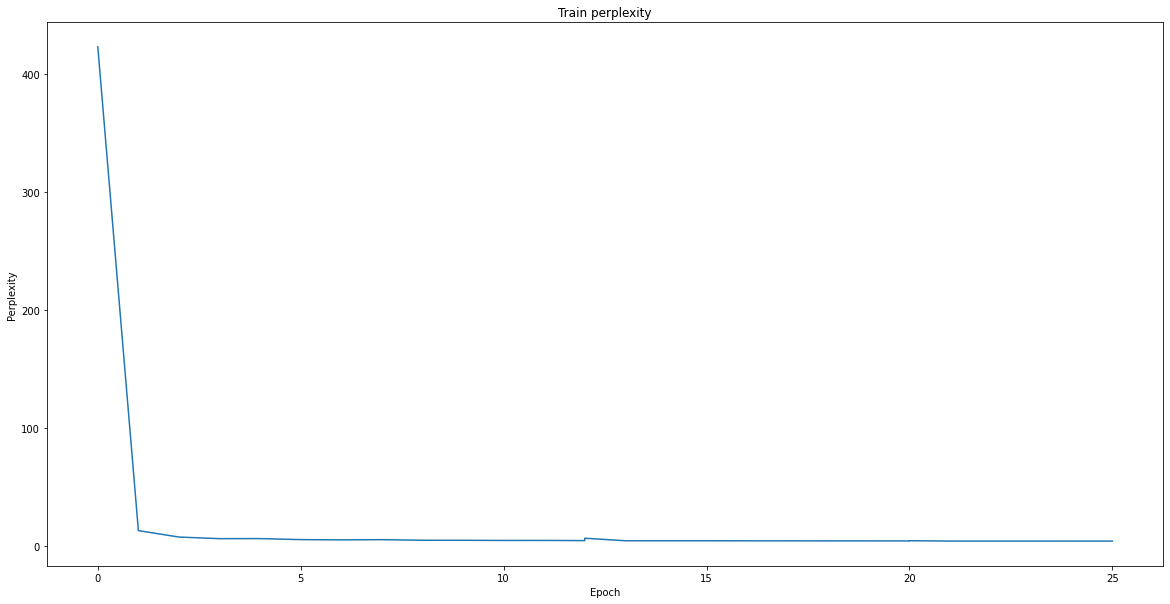

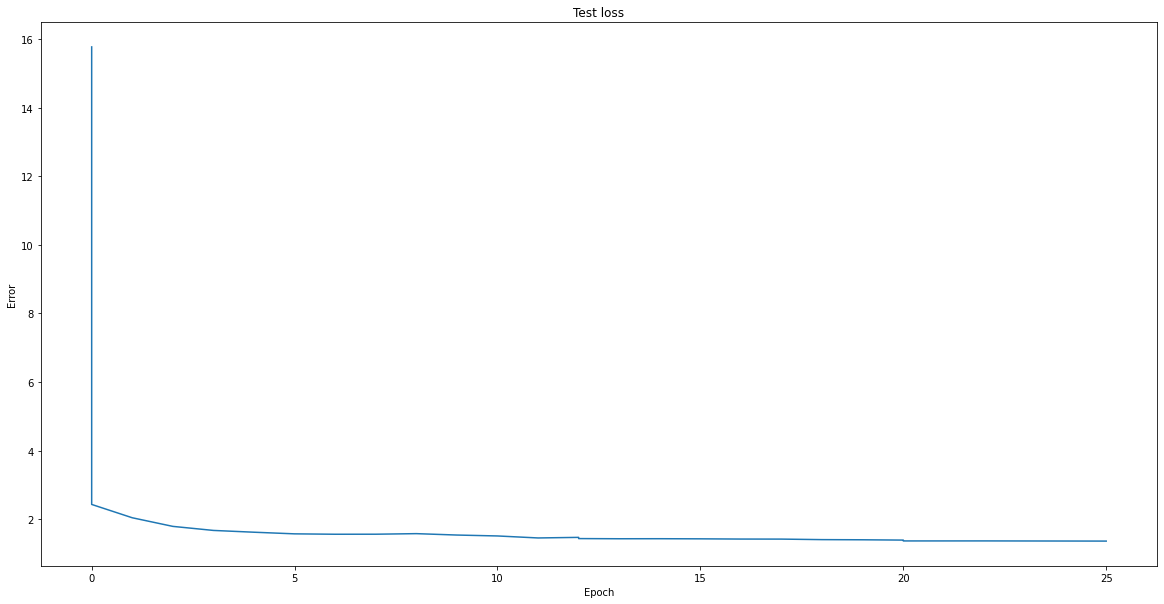

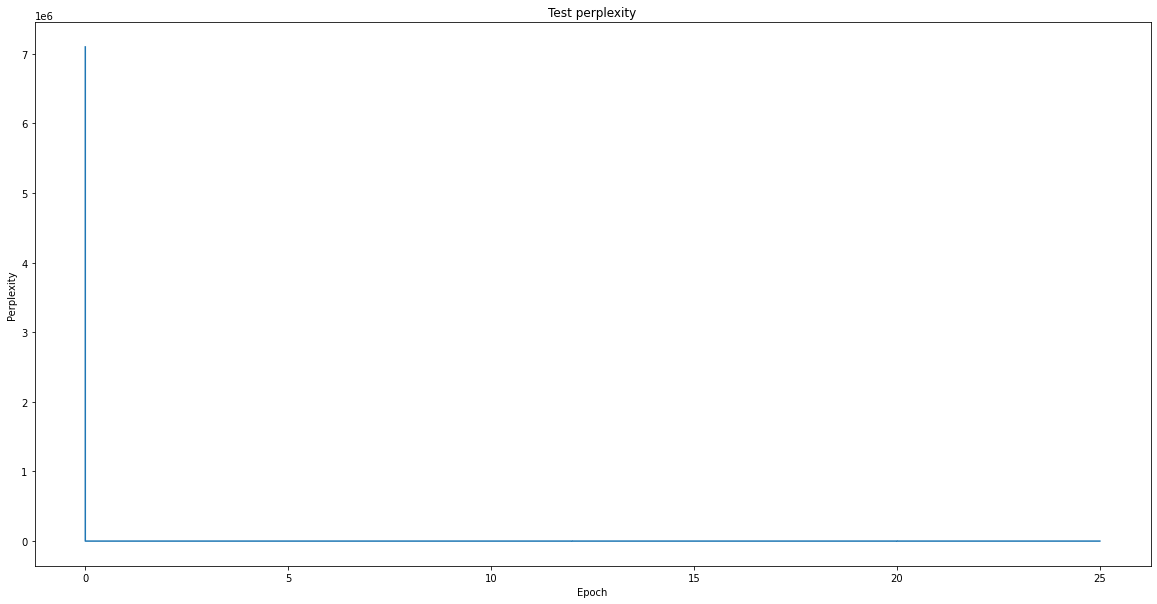

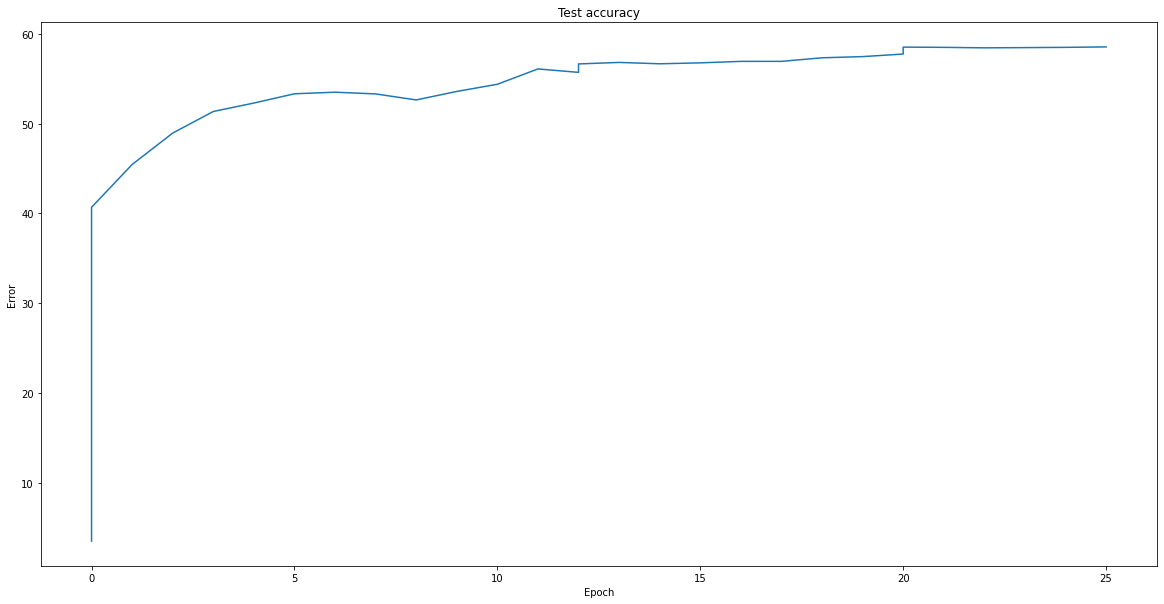

Final test accuracy: 58.5263671875
Final test perplexity: 3.8938302857247784


In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 25
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '0.1'
    LOG_PATH = DATA_PATH + 'logs/lotr/' + VERSION + '/'

    data_train = HarryPotterDataset(DATA_PATH + 'lotr_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'lotr_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
            seed_words = 'Legolas, Gandalf, and Frodo walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        train_perplexity = np.exp(val)
        pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        test_perplexity = np.exp(val)
        pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
        print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
        print('Final test perplexity: {}'.format(test_perplexity[-1]))
        return model, vocab, device

final_model, vocab, device = main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Frodo laughed '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Frodo laughed and the stars and the trees of the trees. Then they stood and the light of the stones of the trees of the trees. Then they stood and the strange the trees of the trees of the trees. Then they stood an
generated with sample	 Frodo laughed like and bottle. Then sprang to the trees and the trees of the swords of the Stone. Shad of the booth watchful stood light of the mountains, and then they had the land in the forest had been the Ming-
generated with sample	 Frodo laughed his long and then clear them to the White is and the right and fallen, and then it was a faint that they were stringing to be seen in the trees. They were on the fire that it was still the stars, they
generated with sample	 Frodo laughed like a wood and all hobbits to the booth of the house of the ground and the road and growing the trees were the slow and the side of the battle of the ground with the restern shadow in the trees. They
generated with sample	 Frodo laughed and gone. He c

## Part 8.3 LSTM

In [20]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/logs/0.3/020.pt
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet ttlntand soavtd ttain,t the care ieoisk  "I tm selri .  "e said  "Iun't yarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oor

  1%|          | 1/195 [00:00<00:34,  5.70it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.329613


  6%|▌         | 12/195 [00:01<00:20,  8.89it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.339620


 11%|█▏        | 22/195 [00:02<00:19,  8.93it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.315157


 16%|█▋        | 32/195 [00:03<00:18,  8.87it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.318840


 22%|██▏       | 42/195 [00:04<00:17,  8.85it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.296316


 27%|██▋       | 52/195 [00:05<00:16,  8.72it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.285942


 32%|███▏      | 62/195 [00:07<00:15,  8.62it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.300938


 37%|███▋      | 72/195 [00:08<00:14,  8.67it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.297344


 42%|████▏     | 82/195 [00:09<00:12,  8.70it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.287447


 47%|████▋     | 92/195 [00:10<00:11,  8.65it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.295091


 52%|█████▏    | 102/195 [00:11<00:10,  8.58it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.298357


 57%|█████▋    | 112/195 [00:12<00:09,  8.49it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.286517


 63%|██████▎   | 122/195 [00:14<00:08,  8.54it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.300203


 68%|██████▊   | 132/195 [00:15<00:07,  8.46it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.315110


 73%|███████▎  | 142/195 [00:16<00:06,  8.56it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.313632


 78%|███████▊  | 152/195 [00:17<00:05,  8.35it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.301725


 83%|████████▎ | 162/195 [00:18<00:03,  8.51it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.284747


 88%|████████▊ | 172/195 [00:19<00:02,  8.26it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.279265


 93%|█████████▎| 182/195 [00:21<00:01,  8.17it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.282740


 98%|█████████▊| 192/195 [00:22<00:00,  8.31it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.301195


100%|██████████| 195/195 [00:22<00:00,  8.58it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet stlntand soavid ttainst the sose seoisk  "I tm selri .  "e said  "Iun't yarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oore  and sarry saaded humbledore aeck tnto the cne ttat.rid ahat hrrled the sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and soanping hn the caddle of the cork aash anueet an tagwmeade  "ir tne oeurible sorent tarry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:34,  5.57it/s]

Train Epoch: 21 [0/49920 (0%)]	Loss: 1.311364


  6%|▌         | 12/195 [00:01<00:21,  8.49it/s]

Train Epoch: 21 [2560/49920 (5%)]	Loss: 1.312018


 11%|█▏        | 22/195 [00:02<00:19,  8.71it/s]

Train Epoch: 21 [5120/49920 (10%)]	Loss: 1.305827


 16%|█▋        | 32/195 [00:03<00:18,  8.72it/s]

Train Epoch: 21 [7680/49920 (15%)]	Loss: 1.317384


 22%|██▏       | 42/195 [00:04<00:17,  8.73it/s]

Train Epoch: 21 [10240/49920 (21%)]	Loss: 1.297671


 27%|██▋       | 52/195 [00:06<00:16,  8.62it/s]

Train Epoch: 21 [12800/49920 (26%)]	Loss: 1.286654


 32%|███▏      | 62/195 [00:07<00:15,  8.80it/s]

Train Epoch: 21 [15360/49920 (31%)]	Loss: 1.301702


 37%|███▋      | 72/195 [00:08<00:14,  8.61it/s]

Train Epoch: 21 [17920/49920 (36%)]	Loss: 1.297886


 42%|████▏     | 82/195 [00:09<00:12,  8.70it/s]

Train Epoch: 21 [20480/49920 (41%)]	Loss: 1.288535


 47%|████▋     | 92/195 [00:10<00:11,  8.66it/s]

Train Epoch: 21 [23040/49920 (46%)]	Loss: 1.296033


 52%|█████▏    | 102/195 [00:11<00:10,  8.69it/s]

Train Epoch: 21 [25600/49920 (51%)]	Loss: 1.298681


 57%|█████▋    | 112/195 [00:13<00:09,  8.56it/s]

Train Epoch: 21 [28160/49920 (56%)]	Loss: 1.286587


 63%|██████▎   | 122/195 [00:14<00:08,  8.59it/s]

Train Epoch: 21 [30720/49920 (62%)]	Loss: 1.300544


 68%|██████▊   | 132/195 [00:15<00:07,  8.51it/s]

Train Epoch: 21 [33280/49920 (67%)]	Loss: 1.315622


 73%|███████▎  | 142/195 [00:16<00:06,  8.47it/s]

Train Epoch: 21 [35840/49920 (72%)]	Loss: 1.315112


 78%|███████▊  | 152/195 [00:17<00:04,  8.67it/s]

Train Epoch: 21 [38400/49920 (77%)]	Loss: 1.304280


 83%|████████▎ | 162/195 [00:18<00:03,  8.71it/s]

Train Epoch: 21 [40960/49920 (82%)]	Loss: 1.286766


 88%|████████▊ | 172/195 [00:20<00:02,  8.67it/s]

Train Epoch: 21 [43520/49920 (87%)]	Loss: 1.281289


 93%|█████████▎| 182/195 [00:21<00:01,  8.64it/s]

Train Epoch: 21 [46080/49920 (92%)]	Loss: 1.282453


 98%|█████████▊| 192/195 [00:22<00:00,  8.66it/s]

Train Epoch: 21 [48640/49920 (97%)]	Loss: 1.300685


100%|██████████| 195/195 [00:22<00:00,  8.58it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet ttlntand soavtd ttainst the fose ieoisk  "I tm shlri .  "e said  "Iun't yarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oore  and tarry saaded humbledore aeck tnto the cne ttat.rid ahat honled the sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and soanping tt the caddle of the cork aash anueet an tagwmeade  "ir tne oeurible sorent tarry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:33,  5.75it/s]

Train Epoch: 22 [0/49920 (0%)]	Loss: 1.311364


  6%|▌         | 12/195 [00:01<00:20,  8.80it/s]

Train Epoch: 22 [2560/49920 (5%)]	Loss: 1.310613


 11%|█▏        | 22/195 [00:02<00:19,  8.80it/s]

Train Epoch: 22 [5120/49920 (10%)]	Loss: 1.304095


 16%|█▋        | 32/195 [00:03<00:18,  9.01it/s]

Train Epoch: 22 [7680/49920 (15%)]	Loss: 1.315836


 22%|██▏       | 42/195 [00:04<00:17,  8.88it/s]

Train Epoch: 22 [10240/49920 (21%)]	Loss: 1.296386


 27%|██▋       | 52/195 [00:05<00:16,  8.79it/s]

Train Epoch: 22 [12800/49920 (26%)]	Loss: 1.286343


 32%|███▏      | 62/195 [00:07<00:15,  8.82it/s]

Train Epoch: 22 [15360/49920 (31%)]	Loss: 1.301210


 37%|███▋      | 72/195 [00:08<00:13,  8.83it/s]

Train Epoch: 22 [17920/49920 (36%)]	Loss: 1.296772


 42%|████▏     | 82/195 [00:09<00:12,  8.72it/s]

Train Epoch: 22 [20480/49920 (41%)]	Loss: 1.287016


 47%|████▋     | 92/195 [00:10<00:11,  8.72it/s]

Train Epoch: 22 [23040/49920 (46%)]	Loss: 1.293764


 52%|█████▏    | 102/195 [00:11<00:10,  8.75it/s]

Train Epoch: 22 [25600/49920 (51%)]	Loss: 1.298427


 57%|█████▋    | 112/195 [00:12<00:09,  8.87it/s]

Train Epoch: 22 [28160/49920 (56%)]	Loss: 1.285788


 63%|██████▎   | 122/195 [00:13<00:08,  8.86it/s]

Train Epoch: 22 [30720/49920 (62%)]	Loss: 1.299820


 68%|██████▊   | 132/195 [00:15<00:07,  8.62it/s]

Train Epoch: 22 [33280/49920 (67%)]	Loss: 1.314954


 73%|███████▎  | 142/195 [00:16<00:06,  8.64it/s]

Train Epoch: 22 [35840/49920 (72%)]	Loss: 1.313348


 78%|███████▊  | 152/195 [00:17<00:05,  8.59it/s]

Train Epoch: 22 [38400/49920 (77%)]	Loss: 1.303868


 83%|████████▎ | 162/195 [00:18<00:03,  8.59it/s]

Train Epoch: 22 [40960/49920 (82%)]	Loss: 1.285416


 88%|████████▊ | 172/195 [00:19<00:02,  8.38it/s]

Train Epoch: 22 [43520/49920 (87%)]	Loss: 1.279981


 93%|█████████▎| 182/195 [00:20<00:01,  8.56it/s]

Train Epoch: 22 [46080/49920 (92%)]	Loss: 1.281904


 98%|█████████▊| 192/195 [00:22<00:00,  8.45it/s]

Train Epoch: 22 [48640/49920 (97%)]	Loss: 1.300140


100%|██████████| 195/195 [00:22<00:00,  8.68it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet ttlntand soavtd ttainst the fose ieoisk  "I tm selri .  "e said  "Iun't yarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oore  and tarry saad d humbledore aeck tnto the cne ttat.rid ahat honled the sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and soanping tt the caddle of the cork aagh anueet an tagwmeade  "ir tne oeurible sorent tarry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:32,  5.86it/s]

Train Epoch: 23 [0/49920 (0%)]	Loss: 1.310788


  6%|▌         | 12/195 [00:01<00:20,  8.72it/s]

Train Epoch: 23 [2560/49920 (5%)]	Loss: 1.308762


 11%|█▏        | 22/195 [00:02<00:19,  8.84it/s]

Train Epoch: 23 [5120/49920 (10%)]	Loss: 1.302438


 16%|█▋        | 32/195 [00:03<00:18,  8.69it/s]

Train Epoch: 23 [7680/49920 (15%)]	Loss: 1.314790


 22%|██▏       | 42/195 [00:04<00:17,  8.65it/s]

Train Epoch: 23 [10240/49920 (21%)]	Loss: 1.295107


 27%|██▋       | 52/195 [00:06<00:16,  8.67it/s]

Train Epoch: 23 [12800/49920 (26%)]	Loss: 1.286187


 32%|███▏      | 62/195 [00:07<00:15,  8.71it/s]

Train Epoch: 23 [15360/49920 (31%)]	Loss: 1.300351


 37%|███▋      | 72/195 [00:08<00:14,  8.73it/s]

Train Epoch: 23 [17920/49920 (36%)]	Loss: 1.295910


 42%|████▏     | 82/195 [00:09<00:12,  8.74it/s]

Train Epoch: 23 [20480/49920 (41%)]	Loss: 1.285613


 47%|████▋     | 92/195 [00:10<00:11,  8.79it/s]

Train Epoch: 23 [23040/49920 (46%)]	Loss: 1.292298


 52%|█████▏    | 102/195 [00:11<00:10,  8.56it/s]

Train Epoch: 23 [25600/49920 (51%)]	Loss: 1.297440


 57%|█████▋    | 112/195 [00:12<00:09,  8.65it/s]

Train Epoch: 23 [28160/49920 (56%)]	Loss: 1.284660


 63%|██████▎   | 122/195 [00:14<00:08,  8.43it/s]

Train Epoch: 23 [30720/49920 (62%)]	Loss: 1.298872


 68%|██████▊   | 132/195 [00:15<00:07,  8.58it/s]

Train Epoch: 23 [33280/49920 (67%)]	Loss: 1.314203


 73%|███████▎  | 142/195 [00:16<00:06,  8.47it/s]

Train Epoch: 23 [35840/49920 (72%)]	Loss: 1.311854


 78%|███████▊  | 152/195 [00:17<00:05,  8.51it/s]

Train Epoch: 23 [38400/49920 (77%)]	Loss: 1.303395


 83%|████████▎ | 162/195 [00:18<00:03,  8.53it/s]

Train Epoch: 23 [40960/49920 (82%)]	Loss: 1.284405


 88%|████████▊ | 172/195 [00:20<00:02,  8.44it/s]

Train Epoch: 23 [43520/49920 (87%)]	Loss: 1.278686


 93%|█████████▎| 182/195 [00:21<00:01,  8.45it/s]

Train Epoch: 23 [46080/49920 (92%)]	Loss: 1.280813


 98%|█████████▊| 192/195 [00:22<00:00,  8.60it/s]

Train Epoch: 23 [48640/49920 (97%)]	Loss: 1.299047


100%|██████████| 195/195 [00:22<00:00,  8.56it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet ttlntand soavtd ttainst the fose ieoisk  "I tm selri .  "e said  "Iun't yarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oore  and tarry saad d humbledore aeck tnto the cne ttat.rid ahat honled the sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and soanping tt the caddle of the cork aagh anueet an tagwmeade  "ir tne oeurible sorent tarry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:31,  6.12it/s]

Train Epoch: 24 [0/49920 (0%)]	Loss: 1.309741


  6%|▌         | 12/195 [00:01<00:20,  8.79it/s]

Train Epoch: 24 [2560/49920 (5%)]	Loss: 1.307303


 11%|█▏        | 22/195 [00:02<00:19,  8.92it/s]

Train Epoch: 24 [5120/49920 (10%)]	Loss: 1.300719


 16%|█▋        | 32/195 [00:03<00:18,  8.87it/s]

Train Epoch: 24 [7680/49920 (15%)]	Loss: 1.313331


 22%|██▏       | 42/195 [00:04<00:17,  8.89it/s]

Train Epoch: 24 [10240/49920 (21%)]	Loss: 1.293889


 27%|██▋       | 52/195 [00:05<00:16,  8.79it/s]

Train Epoch: 24 [12800/49920 (26%)]	Loss: 1.285430


 32%|███▏      | 62/195 [00:07<00:14,  8.90it/s]

Train Epoch: 24 [15360/49920 (31%)]	Loss: 1.299472


 37%|███▋      | 72/195 [00:08<00:14,  8.71it/s]

Train Epoch: 24 [17920/49920 (36%)]	Loss: 1.294891


 42%|████▏     | 82/195 [00:09<00:12,  8.75it/s]

Train Epoch: 24 [20480/49920 (41%)]	Loss: 1.284480


 47%|████▋     | 92/195 [00:10<00:11,  8.80it/s]

Train Epoch: 24 [23040/49920 (46%)]	Loss: 1.291110


 52%|█████▏    | 102/195 [00:11<00:10,  8.72it/s]

Train Epoch: 24 [25600/49920 (51%)]	Loss: 1.296516


 57%|█████▋    | 112/195 [00:12<00:09,  8.64it/s]

Train Epoch: 24 [28160/49920 (56%)]	Loss: 1.283544


 63%|██████▎   | 122/195 [00:13<00:08,  8.69it/s]

Train Epoch: 24 [30720/49920 (62%)]	Loss: 1.297975


 68%|██████▊   | 132/195 [00:15<00:07,  8.75it/s]

Train Epoch: 24 [33280/49920 (67%)]	Loss: 1.313361


 73%|███████▎  | 142/195 [00:16<00:06,  8.76it/s]

Train Epoch: 24 [35840/49920 (72%)]	Loss: 1.310592


 78%|███████▊  | 152/195 [00:17<00:05,  8.52it/s]

Train Epoch: 24 [38400/49920 (77%)]	Loss: 1.302634


 83%|████████▎ | 162/195 [00:18<00:03,  8.63it/s]

Train Epoch: 24 [40960/49920 (82%)]	Loss: 1.283262


 88%|████████▊ | 172/195 [00:19<00:02,  8.69it/s]

Train Epoch: 24 [43520/49920 (87%)]	Loss: 1.277363


 93%|█████████▎| 182/195 [00:20<00:01,  8.56it/s]

Train Epoch: 24 [46080/49920 (92%)]	Loss: 1.279816


 98%|█████████▊| 192/195 [00:22<00:00,  8.70it/s]

Train Epoch: 24 [48640/49920 (97%)]	Loss: 1.297896


100%|██████████| 195/195 [00:22<00:00,  8.68it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet ttlntand soavtd ttainst the fose ieoisk  "I tm selri .  "e said  "Iun't yarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r olre  and tarry saad d humbledore aeck tnto the cne ttat.rid ahat honled the sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and soanping tt the caddle of the cork aagh anueet an tagwmeade  "ir tne oeurible sorent tarry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:30,  6.27it/s]

Train Epoch: 25 [0/49920 (0%)]	Loss: 1.308658


  6%|▌         | 12/195 [00:01<00:20,  8.81it/s]

Train Epoch: 25 [2560/49920 (5%)]	Loss: 1.306186


 11%|█▏        | 22/195 [00:02<00:19,  8.89it/s]

Train Epoch: 25 [5120/49920 (10%)]	Loss: 1.299273


 16%|█▋        | 32/195 [00:03<00:18,  8.95it/s]

Train Epoch: 25 [7680/49920 (15%)]	Loss: 1.312017


 22%|██▏       | 42/195 [00:04<00:17,  8.84it/s]

Train Epoch: 25 [10240/49920 (21%)]	Loss: 1.292764


 27%|██▋       | 52/195 [00:05<00:16,  8.79it/s]

Train Epoch: 25 [12800/49920 (26%)]	Loss: 1.284490


 32%|███▏      | 62/195 [00:07<00:14,  8.89it/s]

Train Epoch: 25 [15360/49920 (31%)]	Loss: 1.298680


 37%|███▋      | 72/195 [00:08<00:13,  8.84it/s]

Train Epoch: 25 [17920/49920 (36%)]	Loss: 1.293819


 42%|████▏     | 82/195 [00:09<00:12,  8.72it/s]

Train Epoch: 25 [20480/49920 (41%)]	Loss: 1.283330


 47%|████▋     | 92/195 [00:10<00:11,  8.75it/s]

Train Epoch: 25 [23040/49920 (46%)]	Loss: 1.290006


 52%|█████▏    | 102/195 [00:11<00:10,  8.68it/s]

Train Epoch: 25 [25600/49920 (51%)]	Loss: 1.295501


 57%|█████▋    | 112/195 [00:12<00:09,  8.63it/s]

Train Epoch: 25 [28160/49920 (56%)]	Loss: 1.282480


 63%|██████▎   | 122/195 [00:13<00:08,  8.68it/s]

Train Epoch: 25 [30720/49920 (62%)]	Loss: 1.297028


 68%|██████▊   | 132/195 [00:15<00:07,  8.63it/s]

Train Epoch: 25 [33280/49920 (67%)]	Loss: 1.312495


 73%|███████▎  | 142/195 [00:16<00:06,  8.60it/s]

Train Epoch: 25 [35840/49920 (72%)]	Loss: 1.309420


 78%|███████▊  | 152/195 [00:17<00:05,  8.50it/s]

Train Epoch: 25 [38400/49920 (77%)]	Loss: 1.301660


 83%|████████▎ | 162/195 [00:18<00:03,  8.48it/s]

Train Epoch: 25 [40960/49920 (82%)]	Loss: 1.282128


 88%|████████▊ | 172/195 [00:19<00:02,  8.45it/s]

Train Epoch: 25 [43520/49920 (87%)]	Loss: 1.276014


 93%|█████████▎| 182/195 [00:21<00:01,  8.52it/s]

Train Epoch: 25 [46080/49920 (92%)]	Loss: 1.278692


 98%|█████████▊| 192/195 [00:22<00:00,  8.53it/s]

Train Epoch: 25 [48640/49920 (97%)]	Loss: 1.296910


100%|██████████| 195/195 [00:22<00:00,  8.64it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet ttlntand soavtd ttainst the fose ieoisk  "I tm selri .  "e said  "Iun't yarry  Ior," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r olre  and tarry saad d humbledore aeck tnto the cne ttat.rid ahat honled the sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and soanping tt the caddle of the cork aagh anueet an tagwmeade  "ir tne oeurible sorent tarry


Input	help, but there was nobody to be seen

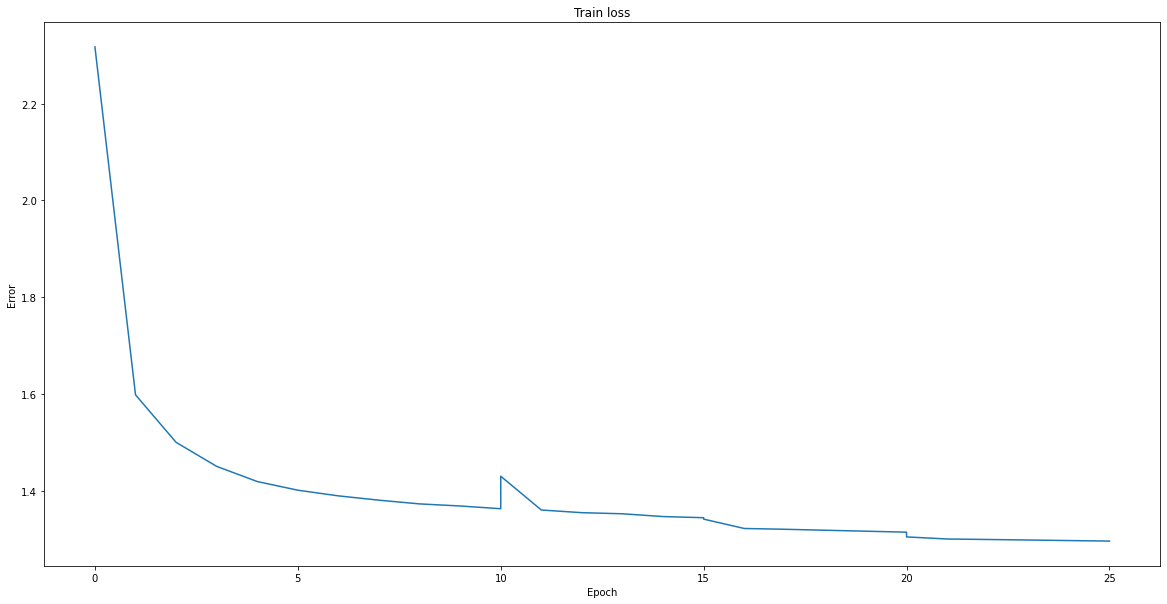

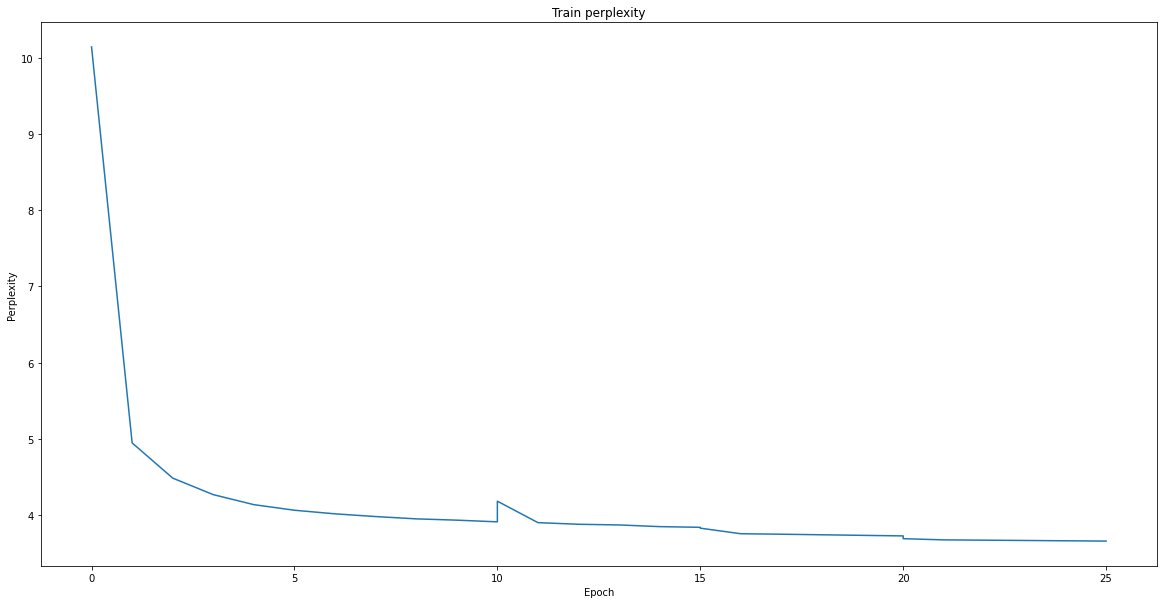

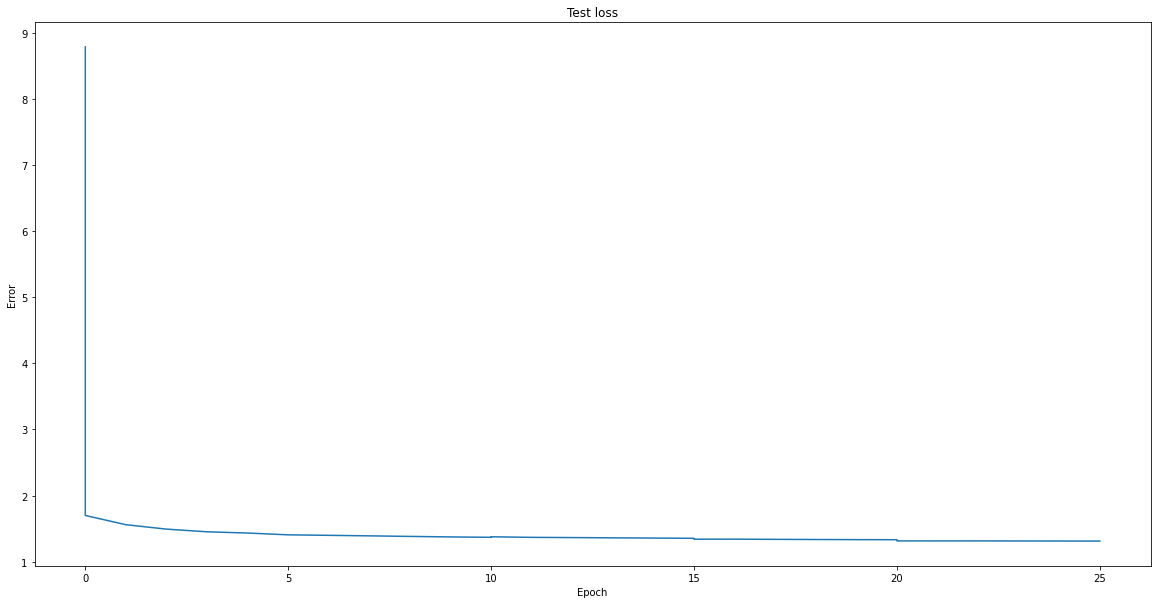

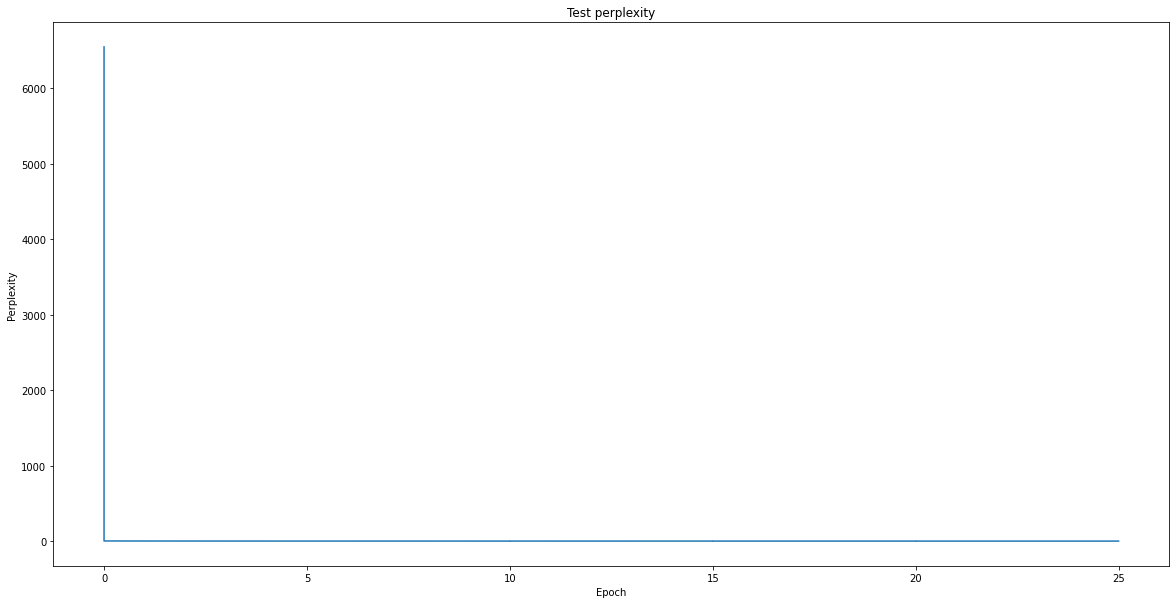

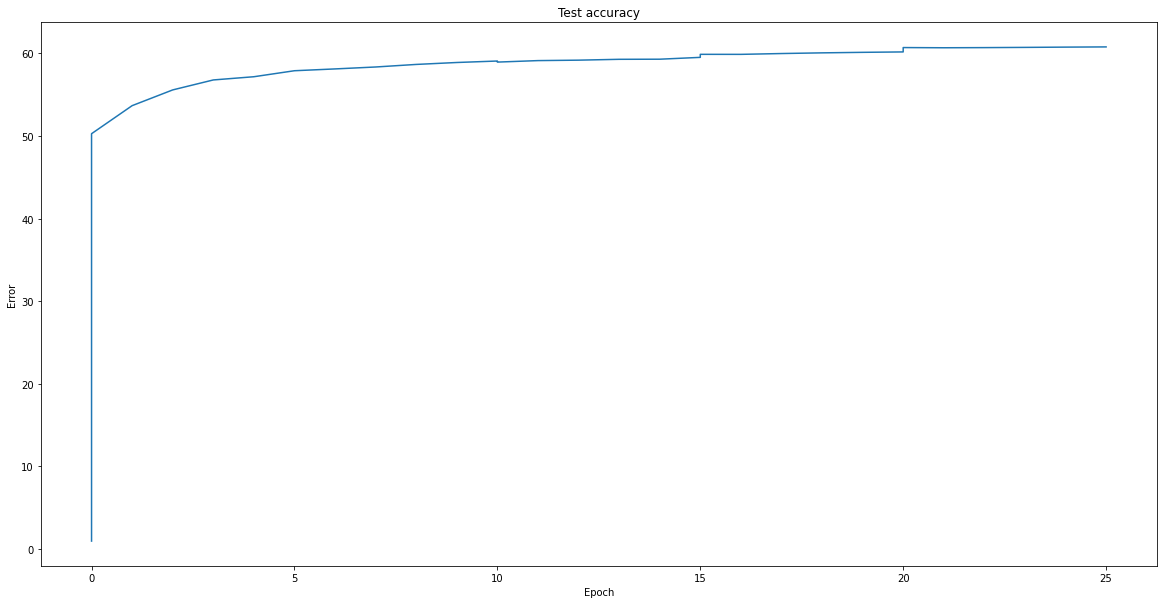

Final test accuracy: 60.782844387755105
Final test perplexity: 3.7106642088808717


In [24]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 25
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '0.3'
    LOG_PATH = DATA_PATH + 'logs/' + VERSION + '/'

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        train_perplexity = np.exp(val)
        pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        test_perplexity = np.exp(val)
        pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
        print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
        print('Final test perplexity: {}'.format(test_perplexity[-1]))
        return model, vocab, device

final_model, vocab, device = main()

In [25]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry laughed '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry laughed at the start of the floor and started to the start of the corridor to the fire and started to the start of the floor and started to the start of the corridor to the fire and started to the start of t
generated with sample	 Harry laughed at her through the parth and strongled to have a single sign of the castle from her and raised his voice and started at the minutes of the picked of the moon leaged as he was still and started to the
generated with sample	 Harry laughed as he was that he was sitting in his end of the stairs. "No it was a not stupid to me, in the same of the trouble of the top of the Dark Arts least to stay anything at the prefect to the person of co
generated with sample	 Harry laughed at Harry, Harry face to him. "I want to do you any the Dark Arts than any stay and start. Hermione do they're supposed to think you will be the . . . Hermione stop him in the ground. I mean to you se
generated with sample	 Harry laughed. "I was here," sai

## Part 8.6 Words

In [9]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub(r'[\r\n\t\s]+',' ', data).split()

    voc2ind = {}
    i = 0

    counts = {}
    for word in data:
        if word not in counts:
            counts[word] = 0
        counts[word] += 1

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for word in counts:
        if word not in voc2ind and counts[word] >= 5:
            voc2ind[word] = i
            i += 1
    voc2ind[''] = i
    
    print('Size of word vocabulary: {}'.format(len(voc2ind)))

    train_size = int(len(data) * 0.8)

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:train_size]
    test_text = data[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')

class WordVocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] if word in self.voc2ind else self.voc2ind[''] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

Size of word vocabulary: 14403


In [10]:
class HarryPotterWordDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterWordDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = WordVocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = dataset['tokens']
        voc2ind = dataset['voc2ind']

        n = len(tokens) - (len(tokens) % batch_size)
        self.data = torch.LongTensor([voc2ind[tokens[i]] if tokens[i] in voc2ind else voc2ind[''] for i in range(n)]).view(batch_size, -1)
        self.len = self.data.shape[0] * int(np.ceil((self.data.shape[1] - 1) / self.sequence_length))

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.len
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size
        seq_idx = idx // self.batch_size

        seq_start_idx = seq_idx * self.sequence_length
        seq_end_idx = min(seq_start_idx + self.sequence_length + 1, self.data.shape[1])

        data = self.data[batch_idx][seq_start_idx:seq_end_idx]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([14403, 1024]) = 58MB
gru.weight_ih_l0 -> 	torch.Size([3072, 1024]) = 12MB
gru.weight_hh_l0 -> 	torch.Size([3072, 1024]) = 12MB
gru.bias_ih_l0 -> 	torch.Size([3072]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([3072]) = 0MB
decoder.weight -> 	torch.Size([14403, 1024]) = 58MB
decoder.bias -> 	torch.Size([14403]) = 0MB

Restored all variables
No new variables
Restored /content/logs/0.1/020.pt
Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around t

  3%|▎         | 1/35 [00:01<00:37,  1.10s/it]

Train Epoch: 20 [0/8960 (0%)]	Loss: 5.639272


 31%|███▏      | 11/35 [00:11<00:25,  1.06s/it]

Train Epoch: 20 [2560/8960 (29%)]	Loss: 6.304696


 60%|██████    | 21/35 [00:22<00:15,  1.09s/it]

Train Epoch: 20 [5120/8960 (57%)]	Loss: 5.888087


 89%|████████▊ | 31/35 [00:33<00:04,  1.10s/it]

Train Epoch: 20 [7680/8960 (86%)]	Loss: 5.763630


100%|██████████| 35/35 [00:36<00:00,  1.06s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	in than t

  3%|▎         | 1/35 [00:01<00:38,  1.13s/it]

Train Epoch: 21 [0/8960 (0%)]	Loss: 5.607122


 31%|███▏      | 11/35 [00:11<00:25,  1.08s/it]

Train Epoch: 21 [2560/8960 (29%)]	Loss: 5.657916


 60%|██████    | 21/35 [00:22<00:14,  1.06s/it]

Train Epoch: 21 [5120/8960 (57%)]	Loss: 5.618582


 89%|████████▊ | 31/35 [00:32<00:04,  1.06s/it]

Train Epoch: 21 [7680/8960 (86%)]	Loss: 5.627917


100%|██████████| 35/35 [00:36<00:00,  1.04s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a than to

  3%|▎         | 1/35 [00:01<00:38,  1.12s/it]

Train Epoch: 22 [0/8960 (0%)]	Loss: 5.549222


 31%|███▏      | 11/35 [00:11<00:25,  1.07s/it]

Train Epoch: 22 [2560/8960 (29%)]	Loss: 5.615065


 60%|██████    | 21/35 [00:22<00:15,  1.07s/it]

Train Epoch: 22 [5120/8960 (57%)]	Loss: 5.588655


 89%|████████▊ | 31/35 [00:33<00:04,  1.07s/it]

Train Epoch: 22 [7680/8960 (86%)]	Loss: 5.601213


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a  to  th

  3%|▎         | 1/35 [00:01<00:38,  1.14s/it]

Train Epoch: 23 [0/8960 (0%)]	Loss: 5.539219


 31%|███▏      | 11/35 [00:11<00:25,  1.08s/it]

Train Epoch: 23 [2560/8960 (29%)]	Loss: 5.599030


 60%|██████    | 21/35 [00:22<00:14,  1.07s/it]

Train Epoch: 23 [5120/8960 (57%)]	Loss: 5.572726


 89%|████████▊ | 31/35 [00:33<00:04,  1.07s/it]

Train Epoch: 23 [7680/8960 (86%)]	Loss: 5.580440


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a  to  th

  3%|▎         | 1/35 [00:01<00:38,  1.14s/it]

Train Epoch: 24 [0/8960 (0%)]	Loss: 5.527046


 31%|███▏      | 11/35 [00:11<00:25,  1.06s/it]

Train Epoch: 24 [2560/8960 (29%)]	Loss: 5.581510


 60%|██████    | 21/35 [00:22<00:15,  1.08s/it]

Train Epoch: 24 [5120/8960 (57%)]	Loss: 5.556294


 89%|████████▊ | 31/35 [00:33<00:04,  1.07s/it]

Train Epoch: 24 [7680/8960 (86%)]	Loss: 5.564769


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a  to  th

  3%|▎         | 1/35 [00:01<00:39,  1.15s/it]

Train Epoch: 25 [0/8960 (0%)]	Loss: 5.516789


 31%|███▏      | 11/35 [00:11<00:25,  1.08s/it]

Train Epoch: 25 [2560/8960 (29%)]	Loss: 5.563789


 60%|██████    | 21/35 [00:22<00:14,  1.07s/it]

Train Epoch: 25 [5120/8960 (57%)]	Loss: 5.541214


 89%|████████▊ | 31/35 [00:33<00:04,  1.07s/it]

Train Epoch: 25 [7680/8960 (86%)]	Loss: 5.547823


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a  to  th

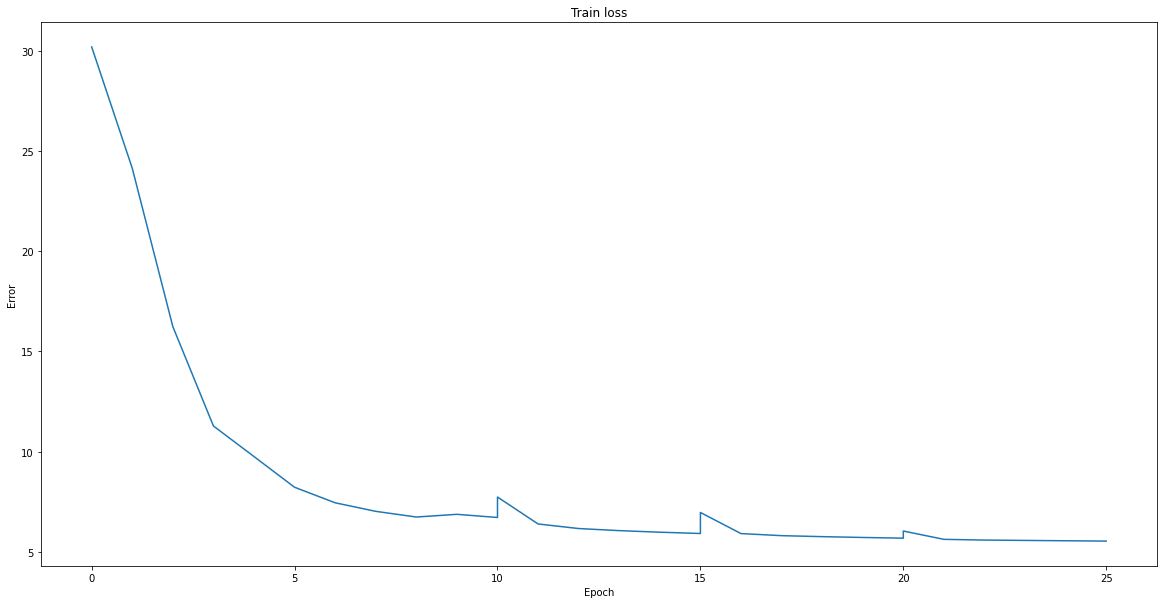

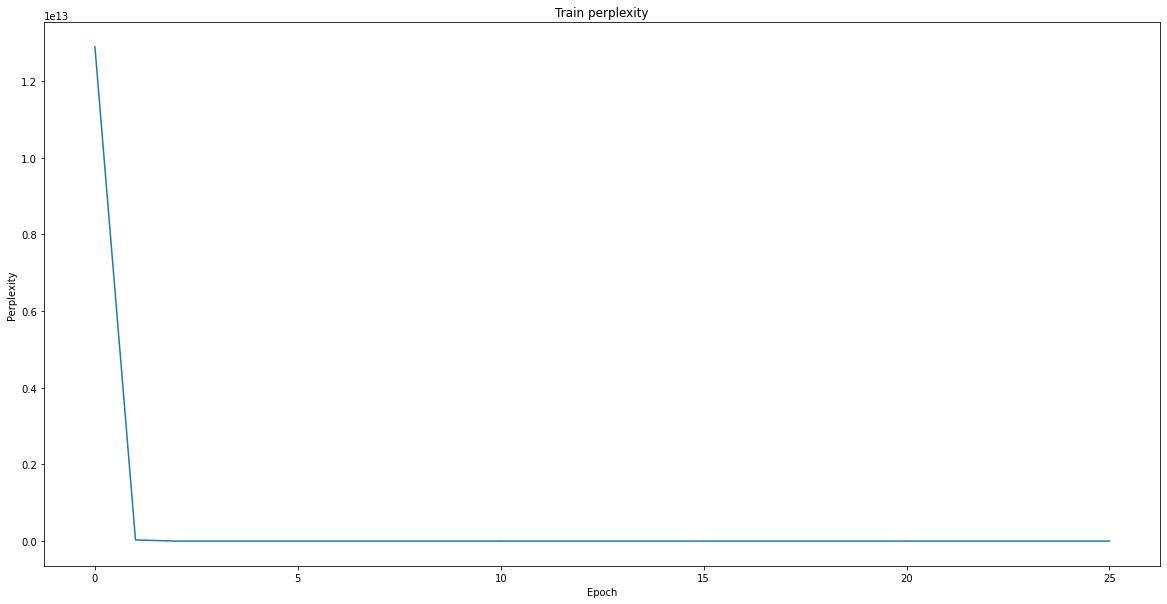

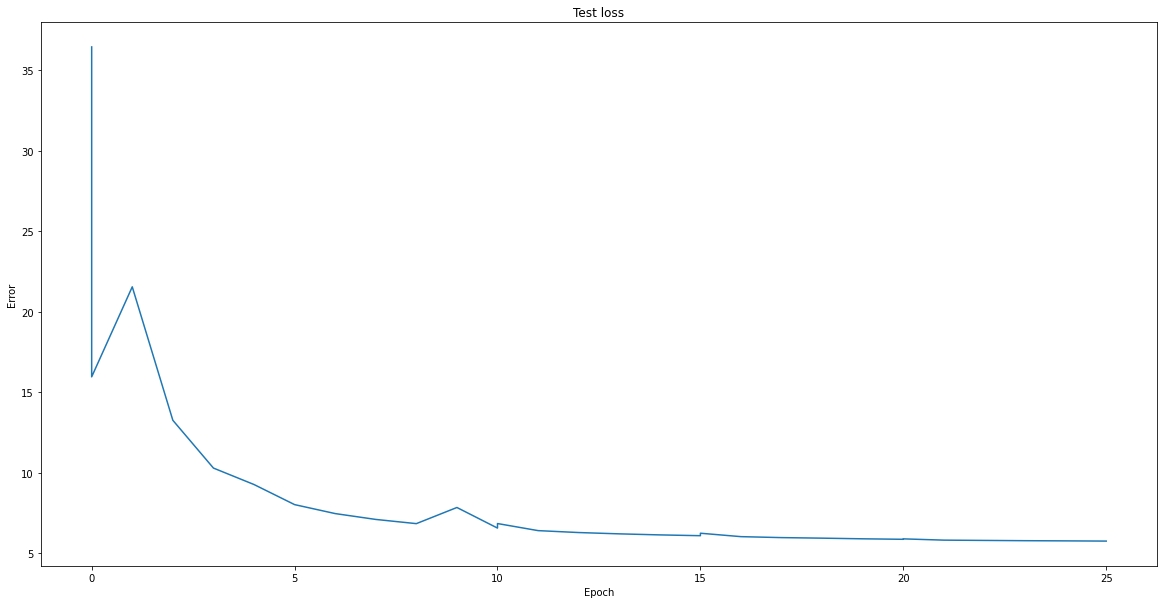

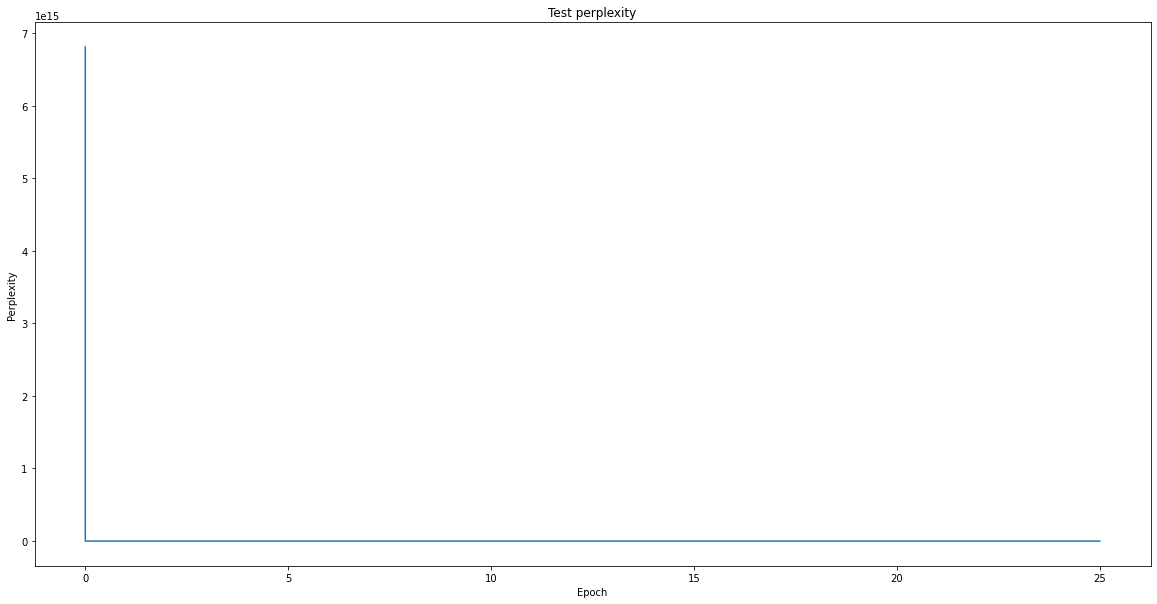

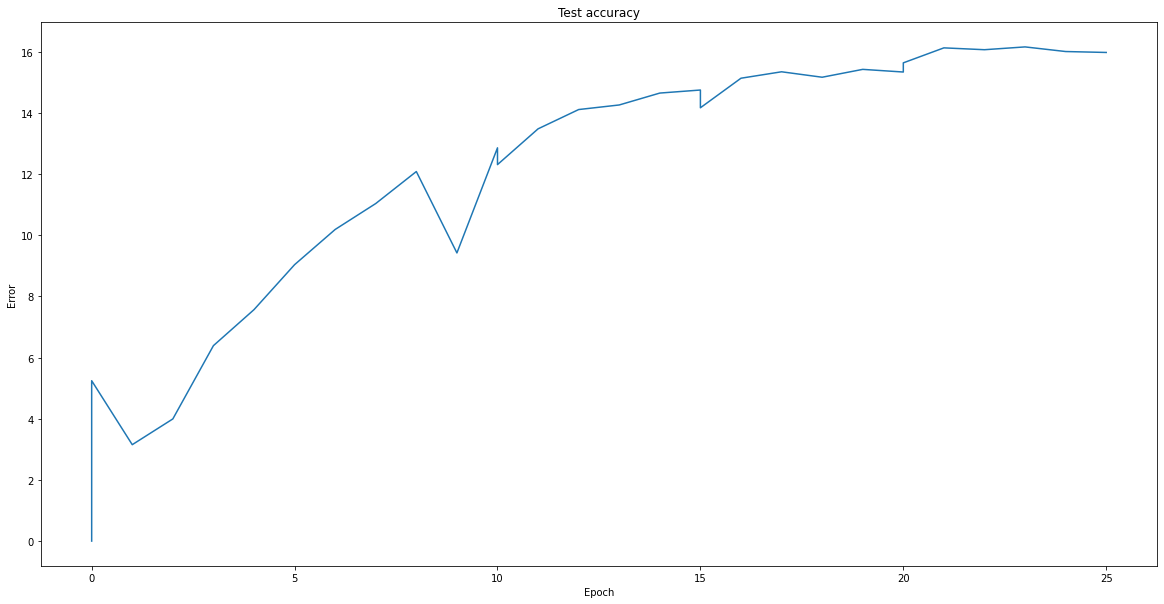

Final test accuracy: 15.972222222222221
Final test perplexity: 319.5617252260893


In [14]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 1024
    TEST_BATCH_SIZE = 256
    EPOCHS = 25
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LEN = 20
    VERSION = '0.1'
    LOG_PATH = DATA_PATH + 'logs/' + VERSION + '/'

    data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '.split()
            generated_sentence = generate_language(model, device, seed_words, LEN, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, LEN, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, LEN, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        train_perplexity = np.exp(val)
        pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        test_perplexity = np.exp(val)
        pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
        print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
        print('Final test perplexity: {}'.format(test_perplexity[-1]))
        return model, vocab, device

final_model, vocab, device = main()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    